In [1]:
"""

snipper.io/s/-MSTCnlcnC3p7aUSnOm_
https://www.kaggle.com/c/clickbait-news-detection/

"""

'\n\nsnipper.io/s/-MSTCnlcnC3p7aUSnOm_\nhttps://www.kaggle.com/c/clickbait-news-detection/\n\n'

In [2]:
sc

<SparkContext master=local[*] appName=PySparkShell>

In [3]:
from copy import deepcopy

from pyspark.ml.feature import Tokenizer, StopWordsRemover, NGram, HashingTF, IDF, CountVectorizer, StringIndexer #Word2Vec, OneHotEncoder, RegexTokenizer,
from pyspark.sql.functions import col, udf, length, avg, lit, concat, size, array, countDistinct
from pyspark.sql.types import IntegerType, StringType, ArrayType
#from pyspark.mllib.classification import NaiveBayes#, NaiveBayesModel
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from pyspark.sql import SparkSession

import re
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
#import nltk
#nltk.download(iwordnet')

In [4]:
try:
    sc.stop()
except:
    print("no sc to stop")

In [5]:
conf = SparkConf().setAppName('clickbait').setMaster('local[2]')
sc = SparkContext.getOrCreate(conf = conf)

In [6]:
spark = SparkSession.builder.appName('ClickBait')\
    .config("spark.executor.memory", "2g")\
    .config("spark.driver.memory", "6g")\
    .getOrCreate()

In [7]:
spark

In [8]:
train_path = "file:///home/hadoop/data/clickbait/train.csv"
#train_path = "hdfs://localhost:9000/data/train.csv;"

In [9]:
# load main training dataframe

t_df = spark.read.csv(train_path, header=True, inferSchema=True, encoding="utf-8")

t_df=t_df.filter((t_df.label == "news")|(t_df.label == "clickbait"))

t_df.persist()

DataFrame[id: string, title: string, text: string, label: string]

In [10]:
t_df.select("label").distinct().show(), t_df.count()

+---------+
|    label|
+---------+
|     news|
|clickbait|
+---------+



(None, 11875)

In [11]:
t_df.filter((t_df.label == "news")).count(),t_df.filter((t_df.label == "clickbait")).count(),

(9371, 2504)

In [12]:
t_df=t_df.na.drop()

t_df.persist()

DataFrame[id: string, title: string, text: string, label: string]

In [13]:
t_df.count()

11807

In [14]:
news_df = t_df.select("*").where(col('label')=="news")
cb_df = t_df.select("*").where(col('label')=="clickbait")

In [15]:
news_df.count(), cb_df.count()

(9327, 2480)

In [16]:
news_seed=4
news_df=news_df.sample(withReplacement=None, fraction=1.0, seed=news_seed).select("*").limit(int(cb_df.count())) # seed selection -9

In [17]:
news_df=news_df.sample(withReplacement=None, fraction=1.0, seed=news_seed).select("*").limit(1600) # 1600
cb_df=cb_df.sample(withReplacement=None, fraction=1.0, seed=news_seed).select("*").limit(1600)

In [18]:
news_df.count(), cb_df.count()

(1600, 1600)

In [19]:
t_df = cb_df.union(news_df)
#t_df = news_df.union(cb_df)
t_df.persist()
t_df.count()

3200

In [20]:
t_df.columns, t_df

(['id', 'title', 'text', 'label'],
 DataFrame[id: string, title: string, text: string, label: string])

In [21]:
t_df.select('title','text','label').limit(20).show()


+--------------------+--------------------+---------+
|               title|                text|    label|
+--------------------+--------------------+---------+
|The Top Beaches I...|Beaches come in a...|clickbait|
|Sheriff’s Report ...|A timeline of wha...|clickbait|
|He Cheated. Now H...|"Get ready to hav...|clickbait|
|Man's commentary ...|Ozzy Man Reviews ...|clickbait|
|Double-Edged Swor...| Shutterstock You...|clickbait|
|#OscarsSoWhite Cr...|#OscarsSoWhite is...|clickbait|
|Health Care, Immi...|(Want to get this...|clickbait|
|Here’s what you s...|You may have hear...|clickbait|
|Old man dances at...|"A video has emer...|clickbait|
|These award-winni...|Kevin Loria 13.01...|clickbait|
|Your Food Craving...|Adele or Rihanna?...|clickbait|
|Amazon just creat...|Kif Leswing, Busi...|clickbait|
|6 Tips To Be More...|Moments and emoti...|clickbait|
|This Cat Yoga Tre...|For cat lovers an...|clickbait|
|Grammys 2017: Wha...|• The Grammy Awar...|clickbait|
|4 Reasons Sleepin...|What i

# Text preprocessing

In [22]:
# Helper UDF functions to remove possessive S and special chars
#from string import punctuation
# def strip_possessive(l_):
#     ptrn=re.compile(r"['`’]s", flags=re.I)
#     r__ = [ptrn.sub('', s_) for s_ in l_]
#     return(r__)  


import re
from string import punctuation
from pyspark.sql.functions import col, udf, length, avg, lit, concat, size, array, countDistinct
print(punctuation)



@udf("string")
def strip_possessive_str(s_):
    #
    ptrn=re.compile(r"['`’]s", flags=re.I)
    r__ = ptrn.sub(' ', s_)
    return(r__)

@udf("string")
def strip_func_str(s_):
    ptrn = re.compile('[\W_]+')
    r__ = ptrn.sub(' ', s_)
    return(r__)

#######################################################################
#
# test cases are not inside a wrapped @udf("schemaType") def func(): 
#display(strip_func_str(strip_possessive_str("Ping's & ^ Biden's & Putin's teams signed document's attributes")))
#"""how is udf on re.compile performing under the hood?"""
#display(strip_possessive_str(punctuation)) 
#display(strip_func_str(strip_possessive_str("Ping's & ^ Biden's team signed document attributes")))
#x = ["World's fair", "Putin's administration", "fergi's song", "Xi's policy"]
#######################################################################

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [23]:
def get_avg_len_cols(df, selection):
    """for str length in pyspark columns"""
    return(
        df \
        .select(*(length(col(c)).alias(c) for c in selection)) \
        .agg(*(avg(col(c)).alias(c) for c in selection)).show()
              )

from collections.abc import Iterable
def get_avg_size_cols(df, selection):
    """for arrays of str in pyspark df"""
    assert isinstance(selection, Iterable)
    return(
        df \
        .select(*(size(col(c)).alias(c) for c in selection)) \
        .agg(*(avg(col(c)).alias(c) for c in selection)).show()
              )

In [24]:
stemmer=SnowballStemmer("english")

lemmatizer = WordNetLemmatizer()

def stem_lem_per_word(word, pos='n'):
    sl_word = stemmer.stem(word)
    sl_word = lemmatizer.lemmatize(sl_word, pos=pos)
    return(sl_word)
    #pos=noun
    

def stem_lem_list(list_of_words, pos='n'):
    # l_ is supposed to be a  column value but nltk stemmers are expecting just a python list?
    r_list = [stem_lem_per_word(w_) for w_ in list_of_words]
    r_list = [w_ for w_ in r_list if w_ not in [""]]
    return(r_list)

@udf("array<string>")
def stem_lem(arr_str):
#    pass
     return stem_lem_list(arr_str)


st_cases=["writing", "write", "wrote", "writing", "written", "drag", "dragged", "dragon", ""]
[stem_lem_per_word(case) for case in st_cases]
#t_df.select("s3").map(stem_lem)
stem_lem_list(st_cases)

['write',
 'write',
 'wrote',
 'write',
 'written',
 'drag',
 'drag',
 'dragon']

In [25]:
# Concatenate title & text fields
# strip_possessive_str : remove possessive s --> "`s", "'s'", "`s"...
# strip_func_str       : remove special characters --> "!","$","."...
t_df=t_df.withColumn("s", 
                strip_func_str(strip_possessive_str(
                    concat(col('title'),col("text")))
                              ))
# t_df = t_df.withColumn("s", strip_func_str(strip_possessive_str(
#     concat(col('title'),col("text")))))

In [26]:
t_df.columns

['id', 'title', 'text', 'label', 's']

In [27]:
selection = ["title", "text", "s"]

display("avg string length of columns")
get_avg_len_cols(t_df, selection)

'avg string length of columns'

+-------+---------+-----------+
|  title|     text|          s|
+-------+---------+-----------+
|73.2125|3539.1875|3499.689375|
+-------+---------+-----------+



In [28]:
# Tokenize string to list
t_df = Tokenizer(inputCol = "s", outputCol = "s1").transform(t_df) # first text transformation is pyspark builtin tokenizer


In [29]:
t_df.printSchema()

root
 |-- id: string (nullable = true)
 |-- title: string (nullable = true)
 |-- text: string (nullable = true)
 |-- label: string (nullable = true)
 |-- s: string (nullable = true)
 |-- s1: array (nullable = true)
 |    |-- element: string (containsNull = true)



In [30]:
t_df.select("s1").sample(withReplacement=False, fraction=1.0, seed=news_seed).show(truncate=True)

# t_df.sample(withReplacement=None, fraction=1, seed=news_seed).select("*").limit(5)
# cb_df.sample(withReplacement=None, fraction=1.0, seed=news_seed).select("*").limit(1600)

+--------------------+
|                  s1|
+--------------------+
|[the, top, beache...|
|[sheriff, report,...|
|[he, cheated, now...|
|[man, commentary,...|
|[double, edged, s...|
|[, oscarssowhite,...|
|[health, care, im...|
|[here, what, you,...|
|[old, man, dances...|
|[these, award, wi...|
|[your, food, crav...|
|[amazon, just, cr...|
|[6, tips, to, be,...|
|[this, cat, yoga,...|
|[grammys, 2017, w...|
|[4, reasons, slee...|
|[nobody, believed...|
|[inside, the, des...|
|[waters, we, have...|
|[property, doctor...|
+--------------------+
only showing top 20 rows



In [31]:
stopwords_pyspark = StopWordsRemover().getStopWords()

stopwords_from_intersection_most_common_1grams=['000',
 '1',
 '10',
 '2',
 '2017',
 '3',
 'according',
 'also',
 'another',
 'around',
 'back',
 'best',
 'breitbart', 
 'company',
 'day',
 'donald',
 'even',
 'every',
 'first',
 'get',
 'go',
 'going',
 'good',
 'home',
 'house',
 'know',
 'last',
 'life',
 'like',
 'long',
 'm',
 'made',
 'make',
 'many',
 'may',
 'million',
 'mr',
 'much',
 'need',
 'new',
 'news',
 'next',
 'old',
 'one',
 'people',
 'percent',
 'president',
 're',
 'right',
 'said',
 'say',
 'says',
 'see',
 'show',
 'since',
 'state',
 'still',
 'take',
 'think',
 'three',
 'time',
 'times',
 'told',
 'trump',
 'twitter',
 'two',
 'u',
 'us',
 'want',
 'way',
 'week',
 'well',
 'women',
 'work',
 'world',
 'year',
 'years',
 ]

In [32]:
display(len(stopwords_pyspark))
stopwords_pyspark+=[w for w in stopwords_from_intersection_most_common_1grams]
display(len(stopwords_pyspark))

181

259

# Stopwords Removal

In [33]:
t_df = StopWordsRemover(inputCol = "s1", outputCol="s2", stopWords=stopwords_pyspark).transform(t_df)


In [34]:
display("difference in avg word array len after StopWordsRemover.transform")
get_avg_size_cols(t_df, ['s1','s2'])

'difference in avg word array len after StopWordsRemover.transform'

+-----------+-----------+
|         s1|         s2|
+-----------+-----------+
|616.2259375|312.6278125|
+-----------+-----------+



In [35]:
t_df.sample(False, 0.1, seed=99).select("s2").limit(5).show(truncate=True)

+--------------------+
|                  s2|
+--------------------+
|[amazon, created,...|
|[musk, surprise, ...|
|[photos, alicia, ...|
|[honestly, rory, ...|
|[drake, mixtape, ...|
+--------------------+



In [36]:
#t_df=t_df.withColumn("s3",stem_lem("s2")) # current stem_lem approach is not helping accuracy
t_df=t_df.withColumn("s3", col("s2"))

In [37]:
t_df.sample(False, 0.1, seed=91).select("s3").limit(5).show(truncate=0)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Assign n-gram columns

In [38]:
from pyspark.ml import Pipeline

ngram_pipeline=Pipeline(stages=[NGram(n=i, inputCol="s3", outputCol= str(i)+"gram") for i in range(1,4)])
m = ngram_pipeline.fit(t_df)
t_df = m.transform(t_df)
t_df.printSchema()

root
 |-- id: string (nullable = true)
 |-- title: string (nullable = true)
 |-- text: string (nullable = true)
 |-- label: string (nullable = true)
 |-- s: string (nullable = true)
 |-- s1: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- s2: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- s3: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- 1gram: array (nullable = true)
 |    |-- element: string (containsNull = false)
 |-- 2gram: array (nullable = true)
 |    |-- element: string (containsNull = false)
 |-- 3gram: array (nullable = true)
 |    |-- element: string (containsNull = false)



In [39]:
# [ngram for ngram in range()]
grams=['{}gram'.format(str(n)) for n in range(1,4)]
["label"]+grams

#t_df.select(*select_args).sample(False, 0.1, seed=91).select("2gram").limit(3).show(truncate=500)

['label', '1gram', '2gram', '3gram']

In [40]:

t_df.select('label', '1gram', '2gram', '3gram').sample(False, 0.1, seed=91).select("2gram").limit(3).show(truncate=True)
t_df.select('label').sample(False, 0.1, seed=91).limit(3).show(truncate=True)

+--------------------+
|               2gram|
+--------------------+
|[double edged, ed...|
|[cat yoga, yoga t...|
|[apple devices, d...|
+--------------------+

+---------+
|    label|
+---------+
|clickbait|
|clickbait|
|clickbait|
+---------+



In [41]:
#Label indexer

indexer = StringIndexer(inputCol="label", outputCol="label_index")
t_df = indexer.fit(t_df).transform(t_df)


t_df.persist()

DataFrame[id: string, title: string, text: string, label: string, s: string, s1: array<string>, s2: array<string>, s3: array<string>, 1gram: array<string>, 2gram: array<string>, 3gram: array<string>, label_index: double]

In [42]:
t_df.select('label',"label_index", '1gram').sample(False, 0.1, seed=91).limit(3).show(truncate=True)
#since split & join by  by label, samples may be coming sequentially 


t_df.select("label_index").distinct().show(), t_df.count()

+---------+-----------+--------------------+
|    label|label_index|               1gram|
+---------+-----------+--------------------+
|clickbait|        0.0|[double, edged, s...|
|clickbait|        0.0|[cat, yoga, trend...|
|clickbait|        0.0|[apple, devices, ...|
+---------+-----------+--------------------+

+-----------+
|label_index|
+-----------+
|        0.0|
|        1.0|
+-----------+



(None, 3200)

In [43]:
t_df.groupBy('label', 'label_index').count().show()

+---------+-----------+-----+
|    label|label_index|count|
+---------+-----------+-----+
|clickbait|        0.0| 1600|
|     news|        1.0| 1600|
+---------+-----------+-----+



In [44]:
# Lines to save preprocessed dataframe to disk or hdfs

# todo parquet
# spark.read.json is having trouble inferring  the schema for required ml datatypes
# manual schema in separate script was not pulling.
# other data sources

PREPROCESSED_DF_CSV_PATH="file:///home/hadoop/cb/pre_train.csv"

#t_df.repartition(1).write.format('com.databricks.spark.csv').save(PREPROCESSED_DF_CSV_PATH,header = 'true')

#t_df.repartition(1).write.json(PREPROCESSED_DF_CSV_PATH,mode="overwrite")

t_df.schema

StructType(List(StructField(id,StringType,true),StructField(title,StringType,true),StructField(text,StringType,true),StructField(label,StringType,true),StructField(s,StringType,true),StructField(s1,ArrayType(StringType,true),true),StructField(s2,ArrayType(StringType,true),true),StructField(s3,ArrayType(StringType,true),true),StructField(1gram,ArrayType(StringType,false),true),StructField(2gram,ArrayType(StringType,false),true),StructField(3gram,ArrayType(StringType,false),true),StructField(label_index,DoubleType,false)))

In [45]:
t_df.columns

['id',
 'title',
 'text',
 'label',
 's',
 's1',
 's2',
 's3',
 '1gram',
 '2gram',
 '3gram',
 'label_index']

# ML Pipeline

In [46]:
# data provides separate test & train in different files but test is not labeled, using random splits on one labeled file

train, test = t_df.randomSplit([.8,.2], seed = 2) #news_seed 4, train/test seed 999, accuracy 1.0??

In [47]:
param_map='' #??

# 1-gram, 2-gram, 3-gram
gramcols=["1gram", "2gram", "3gram"]
pipeline = Pipeline(stages=[
                    CountVectorizer(inputCol=c__ , outputCol=c__+"_cv", minDF=2.0) for c__ in gramcols] +
                    [NaiveBayes(modelType= "multinomial", labelCol="label_index",
                                featuresCol = c__ + "_cv",
                                rawPredictionCol="raw_pred_" + c__,
                                probabilityCol="prob_"+c__,
                                predictionCol="pred_"+c__) for c__ in gramcols]
                   )

In [48]:
pipeline_model = pipeline.fit(train)
pred = pipeline_model.transform(test)

In [49]:
# pipeline_model = pipeline.fit(train) # sometimes this line is failing on ## ValueError("Params must be either a param map or a list/tuple of param maps, "
# pred = pipeline_model.transform(test) # but it works running again?

# Classifier Accuracy

In [50]:

evaluator = MulticlassClassificationEvaluator(labelCol= "label_index", predictionCol = "pred_1gram", 
                                              metricName="accuracy")
evaluator0 = MulticlassClassificationEvaluator(labelCol= "label_index", predictionCol = "pred_2gram", 
                                              metricName="accuracy")
evaluator1 = MulticlassClassificationEvaluator(labelCol= "label_index", predictionCol = "pred_3gram", 
                                              metricName="accuracy")

#nb_accuracy = evaluator.evaluate(nb_predictions)
nb_accuracy = evaluator.evaluate(pred)
nb_accuracy0 = evaluator0.evaluate(pred)
nb_accuracy1 = evaluator1.evaluate(pred)

print("1gram Accuracy : ", nb_accuracy)
print("2gram Accuracy : ", nb_accuracy0)
print("3gram Accuracy : ", nb_accuracy1)

"""#news seed 2: 0.68
#news seed 3: 0.68
#news seed 4: 0.68

main_args={"stem_lem":True,
          "curated stopwords":True,
          "algo":"NaiveBayes"}

1gram Accuracy :  0.6728395061728395
2gram Accuracy :  0.6790123456790124
3gram Accuracy :  0.6358024691358025


accuracy without stem with curated:

"""

1gram Accuracy :  0.6851851851851852
2gram Accuracy :  0.6867283950617284
3gram Accuracy :  0.6203703703703703


'#news seed 2: 0.68\n#news seed 3: 0.68\n#news seed 4: 0.68\n\nmain_args={"stem_lem":True,\n          "curated stopwords":True,\n          "algo":"NaiveBayes"}\n\n1gram Accuracy :  0.6728395061728395\n2gram Accuracy :  0.6790123456790124\n3gram Accuracy :  0.6358024691358025\n\n\naccuracy without stem with curated:\n\n'

In [51]:
# evaluator_pipeline = [MulticlassClassificationEvaluator(labelCol= "label_index", predictionCol = "pred_{}gram".format(n), 
#                                               metricName="accuracy") for n in range(1,4)])

#[ep.fit(pred) for ep in evaluator_pipeline]
#eval_results = evaluator_pipeline.fit(pred)

dir()


['ArrayType',
 'CountVectorizer',
 'HashingTF',
 'IDF',
 'In',
 'IntegerType',
 'Iterable',
 'MulticlassClassificationEvaluator',
 'NGram',
 'NaiveBayes',
 'Out',
 'PREPROCESSED_DF_CSV_PATH',
 'Pipeline',
 'SQLContext',
 'SnowballStemmer',
 'SparkConf',
 'SparkContext',
 'SparkSession',
 'StopWordsRemover',
 'StringIndexer',
 'StringType',
 'Tokenizer',
 'WordNetLemmatizer',
 '_',
 '_1',
 '_10',
 '_11',
 '_12',
 '_13',
 '_15',
 '_18',
 '_19',
 '_2',
 '_20',
 '_24',
 '_26',
 '_39',
 '_41',
 '_42',
 '_44',
 '_45',
 '_50',
 '_7',
 '_9',
 '__',
 '___',
 '__builtin__',
 '__builtins__',
 '__doc__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_dh',
 '_i',
 '_i1',
 '_i10',
 '_i11',
 '_i12',
 '_i13',
 '_i14',
 '_i15',
 '_i16',
 '_i17',
 '_i18',
 '_i19',
 '_i2',
 '_i20',
 '_i21',
 '_i22',
 '_i23',
 '_i24',
 '_i25',
 '_i26',
 '_i27',
 '_i28',
 '_i29',
 '_i3',
 '_i30',
 '_i31',
 '_i32',
 '_i33',
 '_i34',
 '_i35',
 '_i36',
 '_i37',
 '_i38',
 '_i39',
 '_i4',
 '_i40',
 '_i41',
 '_i42',

In [52]:
t_df.where(col("label")=="clickbait").select('1gram')

DataFrame[1gram: array<string>]

In [53]:
from pyspark.sql.functions import explode

def token_freqs_to_pandas(df, label, column00, lim=1024):
    to_p = t_df.where(col("label")==label).withColumn('token', explode(col(column00)))\
            .groupBy('token')\
            .count()\
            .limit(lim)\
            .sort('count', ascending=False)\
            .toPandas()  
    return(to_p)



In [54]:
token_freqs_to_pandas(t_df, "clickbait", "1gram",)

,token,count
0,7,502
1,often,384
2,taking,277
3,online,268
4,watch,261
5,highest,210
6,anti,180
7,leave,180
8,growth,177
9,include,173


In [55]:
news_1grams_pandas = token_freqs_to_pandas(t_df, "news", "1gram",)

news_2grams_pandas = token_freqs_to_pandas(t_df, "news", "2gram",)

cb_1grams_pandas = token_freqs_to_pandas(t_df, "clickbait", "1gram",)

cb_2grams_pandas = token_freqs_to_pandas(t_df, "clickbait", "2gram",)


[display(df.head()) for df in [news_1grams_pandas, news_2grams_pandas, cb_1grams_pandas, cb_2grams_pandas,]]

,token,count
0,7,445
1,countries,346
2,often,285
3,taking,276
4,growth,238


,token,count
0,co uk,21
1,century fox,14
2,coast guard,12
3,doesn mean,11
4,footage shows,9


,token,count
0,7,502
1,often,384
2,taking,277
3,online,268
4,watch,261


,token,count
0,doesn mean,35
1,fifty shades,18
2,tax bracket,14
3,obamacare replacement,10
4,author igcolonel,8


[None, None, None, None]

In [56]:
# news_2grams_pandas = t_df.where(col("label")=="news").withColumn('token', explode(col('2gram')))\
#     .groupBy('word')\
#     .count()\
#     .sort('count', ascending=False)\
#     .toPandas()

# cb_2grams_pandas = t_df.where(col("label")=="clickbait").withColumn('word', explode(col('2gram')))\
#     .groupBy('word')\
#     .count()\
#     .sort('count', ascending=False)\
#     .toPandas()

In [57]:
#news_2grams_pandas,cb_2grams_pandas

# Most frequent tokens of each set

In [58]:
display(cb_1grams_pandas.iloc[:100].token.values,
news_1grams_pandas.iloc[:100].token.values,)

top_100_tokens_intersection=set(news_1grams_pandas.iloc[:100].token.values).intersection( set(cb_1grams_pandas.iloc[:100].token.values))

top_100_tokens_intersection

array(['7', 'often', 'taking', 'online', 'watch', 'highest', 'anti',
       'leave', 'growth', 'include', 'countries', 'wall', 'hope', 'film',
       'received', 'worked', 'staff', 'travel', 'art', 'spending',
       'parts', 'ready', 'israel', 'conversation', 'character',
       'positive', 'brands', 'television', 'australia', 'grow', 'debate',
       'explain', 'harry', 'prevent', 'plane', 'connected', 'typically',
       'academy', 'oscar', 'slightly', 'cook', 'filled', 'boost',
       'launch', 'cia', 'ira', 'standards', 'falls', 'shut', 'everyday',
       'map', 'operation', 'dozen', 'opposition', 'farm', 'battery',
       'harder', 'lies', 'achieve', 'disaster', '51', 'ukraine',
       'medicare', 'suicide', 'traffic', 'crust', 'slow', 'perspective',
       'extension', 'filing', 'photograph', '800', 'dough', 'romantic',
       'vegetables', 'dishes', 'valley', 'killer', 'premiere', 'stomach',
       'trail', 'evil', 'priority', 'gloria', 'defeated', 'circumstances',
       'embr

array(['7', 'countries', 'often', 'taking', 'growth', 'film', 'wall',
       'watch', 'travel', 'leave', 'anti', 'spending', 'received',
       'online', 'staff', 'hope', 'worked', 'include', 'opposition',
       'art', 'israel', 'assad', 'television', 'positive', 'ready',
       'highest', 'parts', 'character', 'debate', 'conversation', 'grow',
       'vladimir', 'plane', 'launch', 'oscar', 'operation', 'harry',
       'slow', 'valley', 'suicide', 'prevent', 'australia', 'boost',
       'typically', 'involving', 'pipeline', '51', 'battery', 'standards',
       'slightly', 'shut', 'harder', 'filled', 'parks', 'terrorists',
       'dozen', 'farm', 'traveling', 'killer', 'cia', 'connected',
       'achieve', 'disaster', 'equal', 'traffic', 'incoming', 'cable',
       'settlement', 'explain', 'cook', 'circumstances', 'map', 'bench',
       'priority', 'trail', 'brands', 'stations', 'academy', 'lies',
       '800', 'rankings', 'mason', 'embrace', 'approached', 'premiere',
       'perspecti

{'1970s',
 '51',
 '7',
 '800',
 'academy',
 'achieve',
 'anti',
 'art',
 'australia',
 'battery',
 'boost',
 'brands',
 'character',
 'cia',
 'circumstances',
 'colleges',
 'connected',
 'conversation',
 'cook',
 'countries',
 'debate',
 'disaster',
 'dozen',
 'embrace',
 'equal',
 'explain',
 'falls',
 'farm',
 'filing',
 'filled',
 'film',
 'grow',
 'growth',
 'harder',
 'harry',
 'highest',
 'hope',
 'include',
 'israel',
 'killer',
 'launch',
 'leave',
 'lies',
 'map',
 'often',
 'online',
 'operation',
 'opposition',
 'oscar',
 'parts',
 'perspective',
 'photograph',
 'plane',
 'positive',
 'premiere',
 'prevent',
 'priority',
 'ready',
 'received',
 'romantic',
 'shut',
 'slightly',
 'slow',
 'spending',
 'staff',
 'standards',
 'suicide',
 'taking',
 'television',
 'traffic',
 'trail',
 'travel',
 'typically',
 'valley',
 'vladimir',
 'wall',
 'watch',
 'worked'}

In [59]:
import wordcloud

In [60]:
stopwords = wordcloud.STOPWORDS
display(len(stopwords))
stopwords= stopwords.union(top_100_tokens_intersection)
stopwords= stopwords.union(set(stopwords_pyspark))
display(len(stopwords))

192

348

In [61]:
import matplotlib.pyplot as plt

In [62]:
def wc_func(pandas_df):
    """wordcloud function from pandas df of counts in above notebook"""
    freqs=pandas_df.set_index("token").to_dict()['count']
    wc_r = wordcloud.WordCloud(width = 1600, height = 800, 
                background_color ='black', 
                stopwords = stopwords, 
                min_font_size = 10)\
    .generate_from_frequencies(frequencies=freqs)    
    plt.figure(figsize=(16,8))
    plt.imshow(wc_r)
    plt.show()
    return

# Most common unigrams

In [63]:
[display(df.head()) for df in [news_1grams_pandas, cb_1grams_pandas]]


,token,count
0,7,445
1,countries,346
2,often,285
3,taking,276
4,growth,238


,token,count
0,7,502
1,often,384
2,taking,277
3,online,268
4,watch,261


[None, None]

"Top 1-grams from 'news' label"

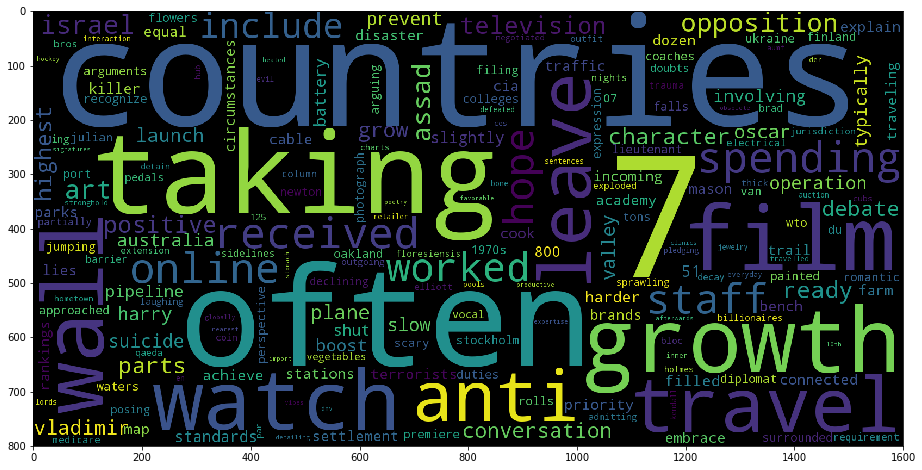

In [64]:
display("Top 1-grams from 'news' label")

wc_func(news_1grams_pandas)
plt.show()

"Top 1-grams from 'clickbait' label"

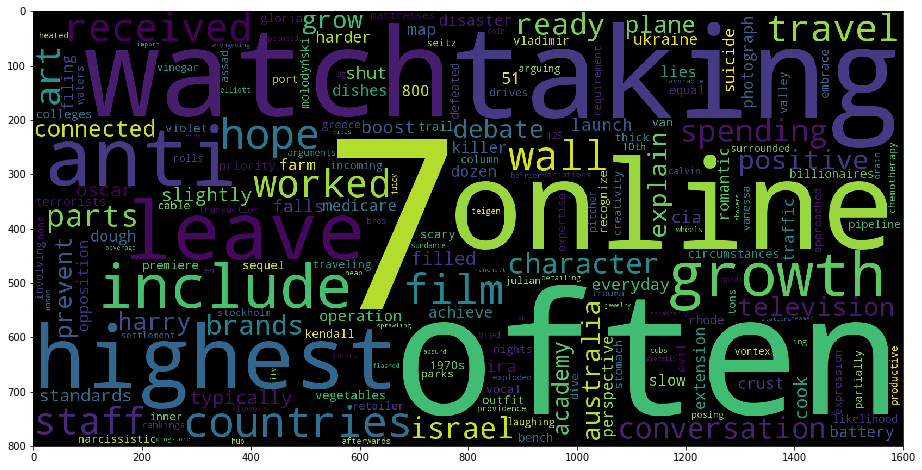

In [65]:
display("Top 1-grams from 'clickbait' label")

wc_func(cb_1grams_pandas)

plt.show()

# Most common bigrams

"Top 2-grams in 'news' label"

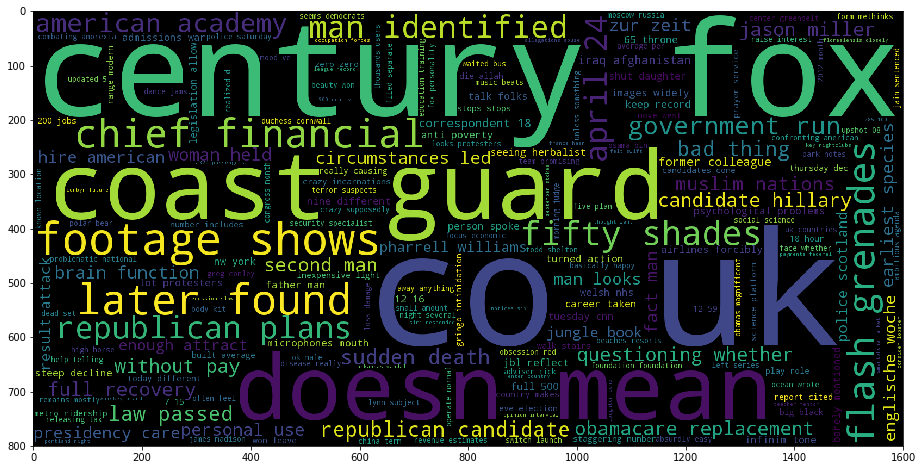

In [66]:
display("Top 2-grams in 'news' label")
wc_func(news_2grams_pandas)

"Top 2-grams in 'clickbait' label"

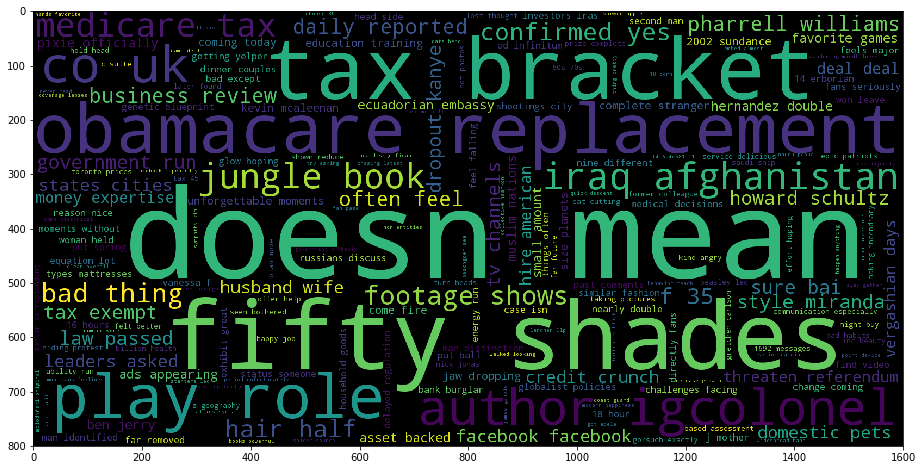

In [67]:
display("Top 2-grams in 'clickbait' label")
wc_func(cb_2grams_pandas)

# Most common trigrams

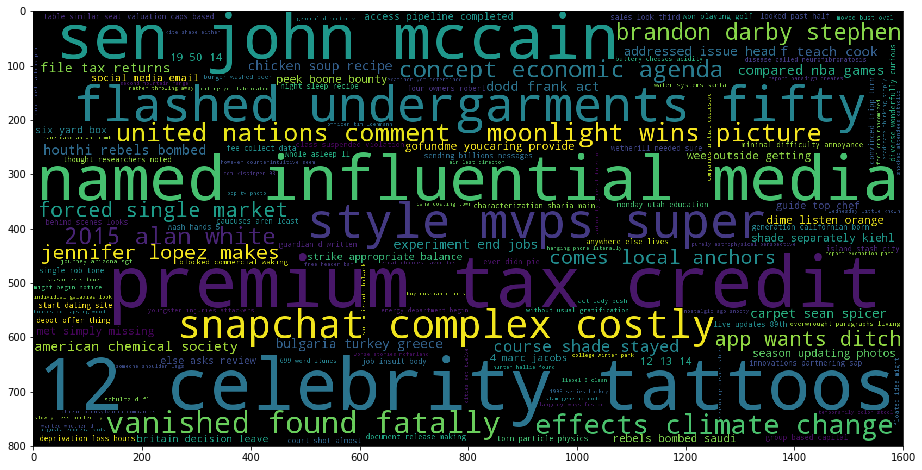

In [68]:
x=token_freqs_to_pandas(t_df, "clickbait", "3gram")
wc_func(x)

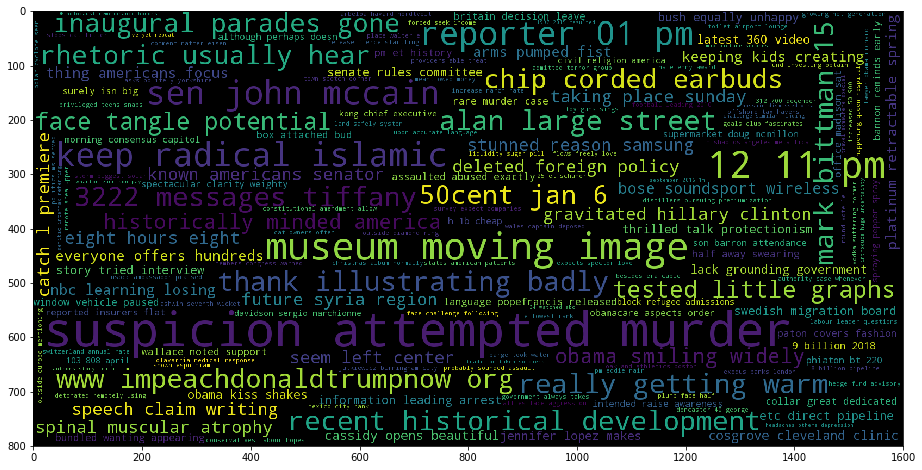

In [69]:
news_3gram_pandas=token_freqs_to_pandas(t_df, "news", "3gram")
wc_func(news_3gram_pandas)